##### Kütüphaneler ve verilerin yüklenmesi

In [1]:
from learntools.time_series.utils import (plot_periodogram, seasonal_plot, plot_lags, make_lags, make_leads,
                                          make_multistep_target, plot_multistep)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import RegressorChain
from pyearth import Earth
from hybrid_model import BoostedHybrid

import warnings

warnings.simplefilter('ignore')

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

##### Verilerin Hazılanması

In [2]:
store_sales = pd.read_csv(
    'datasets\\train.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint64',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [3]:
family_sales = (
    store_sales
        .groupby(['family', 'date'])
        .mean()
        .unstack('family')
    #.loc['2017']
)

sales_name = 'AUTOMOTIVE'
df = pd.DataFrame(family_sales['sales'][sales_name])
df_onpromotion = pd.DataFrame(family_sales['onpromotion'][sales_name])

In [4]:
holidays_events = pd.read_csv(
    'datasets\\holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays_events = holidays_events.set_index('date').to_period('D')

In [5]:
test = pd.read_csv(
    'datasets\\test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

test_family_sales = (
    test
        .groupby(['family', 'date'])
        .mean()
        .unstack('family')
    #.loc['2017']
)

df_test_onpro = pd.DataFrame(test_family_sales['onpromotion'][sales_name])

##### Time-step Features

In [6]:
df_copy = df.copy()

dp = DeterministicProcess(
    index=df_copy.index,
    order=1,
)

X = dp.in_sample()
y = df_copy.loc[:, sales_name]

In [7]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=X.index,
)

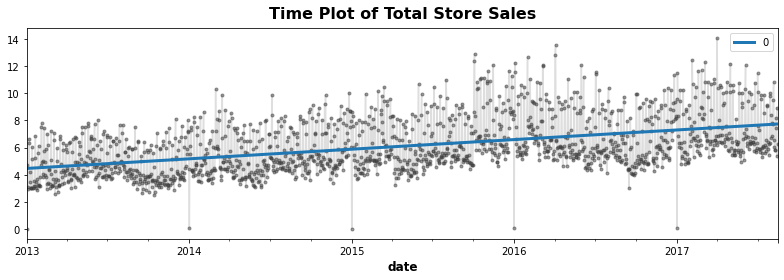

In [8]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

##### Lag Features

In [9]:
lag_1 = df_copy.shift(1)

df_copy['lag_1'] = lag_1

X = df_copy.loc[:, ['lag_1']].dropna()
y = df_copy.loc[:, sales_name]

y, X = y.align(X, join='inner')

In [10]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(
    model.predict(X),
    index=X.index,
)

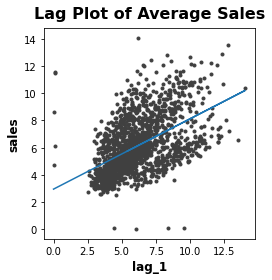

In [11]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

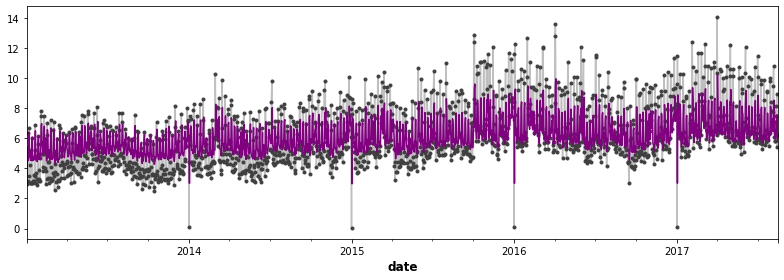

In [12]:
ax = y.plot(**plot_params)
ax = y_pred.plot(color='purple')

### Trend

In [13]:
trend = df_copy.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

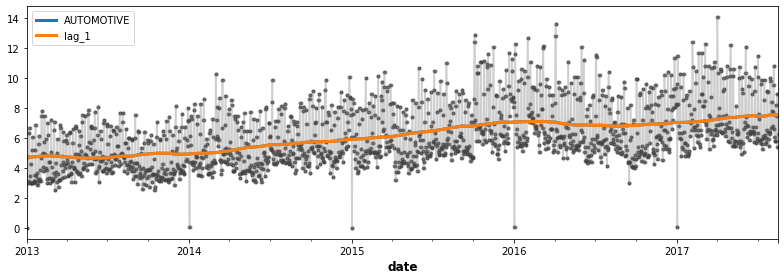

In [14]:
ax = df_copy.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

##### Earth

In [15]:
y = df.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

In [16]:
model = Earth()
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=[sales_name])

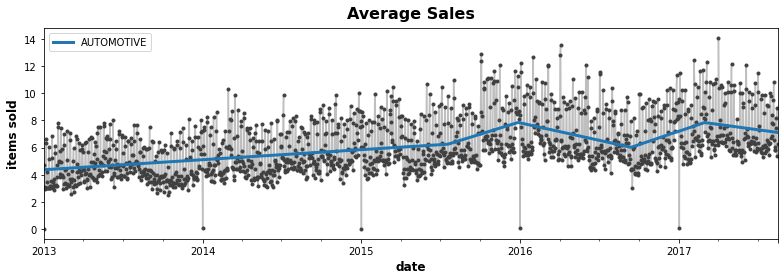

In [17]:
ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

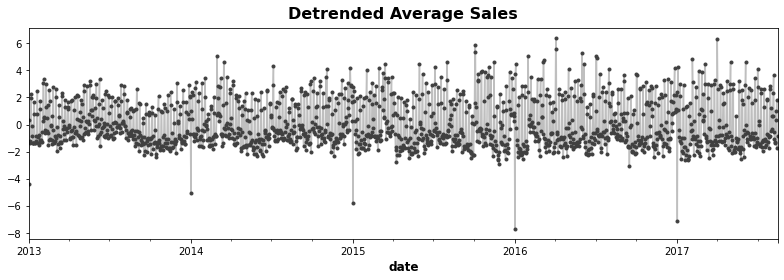

In [18]:
y_detrended = y - y_pred

y_detrended.plot(**plot_params, title="Detrended Average Sales");

### Seasonality

In [19]:
y_detrended_2017 = y_detrended.loc['2017']

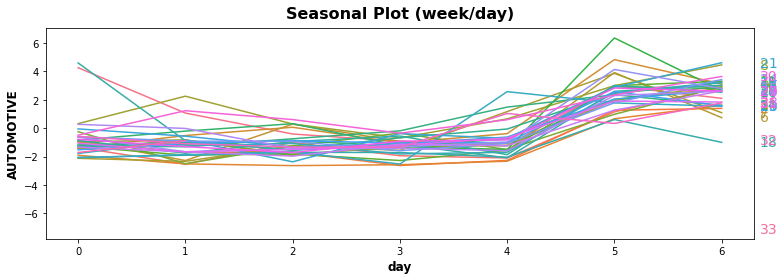

In [20]:
X = y_detrended_2017.copy()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, y=sales_name, period='week', freq='day');

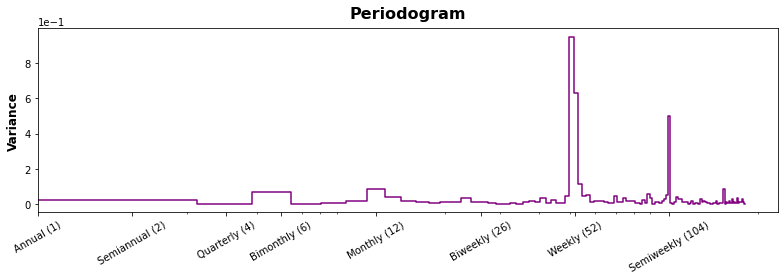

In [21]:
y_detrended_2017 = y_detrended_2017.squeeze()
plot_periodogram(y_detrended_2017);

In [22]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y_detrended_2017.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


In [23]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y_detrended_2017)

y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted'
)

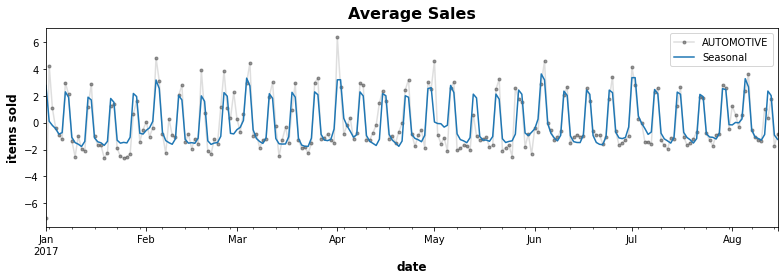

In [24]:
ax = y_detrended_2017.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [25]:
y_deseason = y_detrended_2017 - y_pred

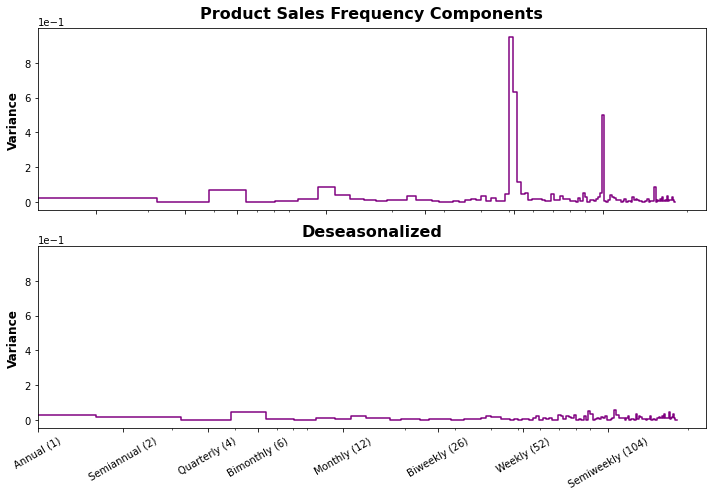

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_detrended_2017, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

###### Holiday

In [27]:
holidays = (
    holidays_events
        .query("locale in ['National', 'Regional']")
        .loc['2017':'2017-08-15', ['description']]
        .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


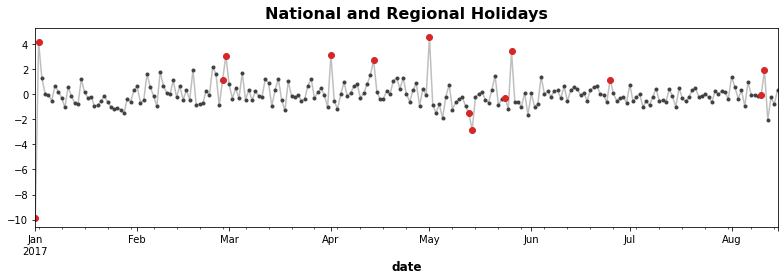

In [28]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [29]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)
X2['NewYearsDay'] = (X2.index.dayofyear == 1)
y_detrended_2017, X2 = y_detrended_2017.align(X2, join='inner')

In [30]:
model = LinearRegression(fit_intercept=True)
model.fit(X2, y_detrended_2017)

y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

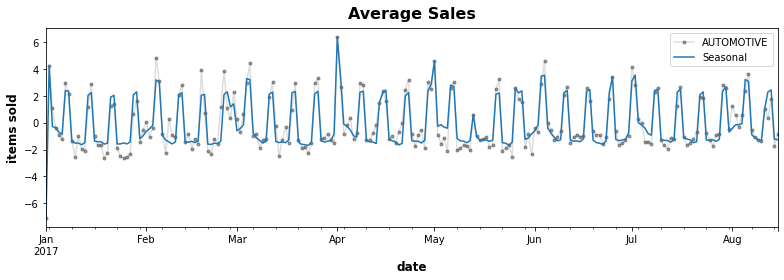

In [31]:
ax = y_detrended_2017.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [32]:
y_deseason = y_detrended_2017 - y_pred

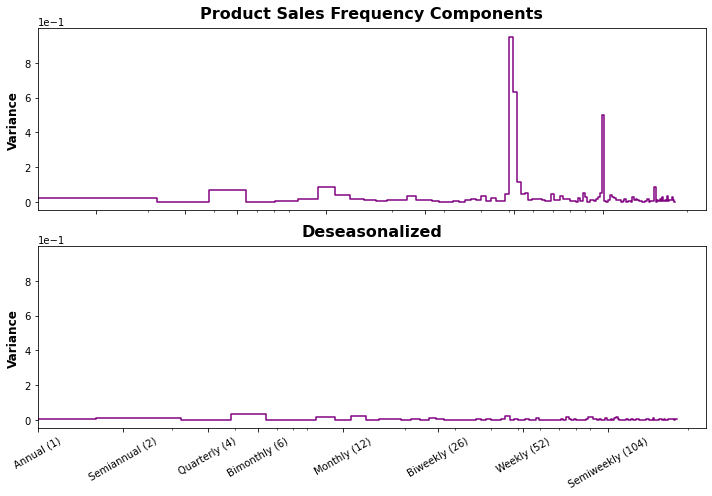

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_detrended_2017, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

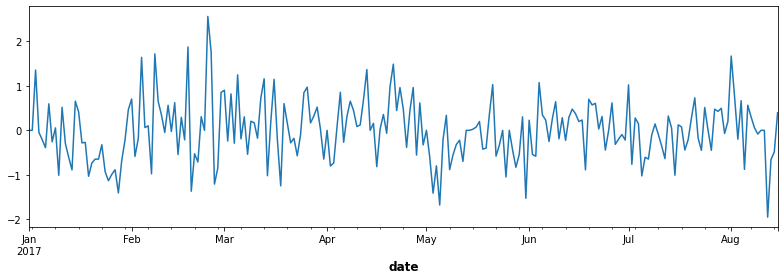

In [34]:
y_deseason.plot();

### Hybrid Models

In [35]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()

        self.model_2.fit(X_2, y_resid)

        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()

        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()

In [36]:
# Linear
dp = DeterministicProcess(index=y.loc['2017'].index, order=1)
X_1 = dp.in_sample()

In [37]:
# XGBoost
X_2 = df_onpromotion.loc['2017'].copy()
X_2["day"] = X_2.index.day

y_deseason = pd.DataFrame(y_deseason)

In [38]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

In [39]:
y_train, y_valid = y_deseason[:"2017-07-01"], y_deseason["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2[: "2017-07-01"], X_2["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train)
y_pred = model.predict(X1_valid, X2_valid)

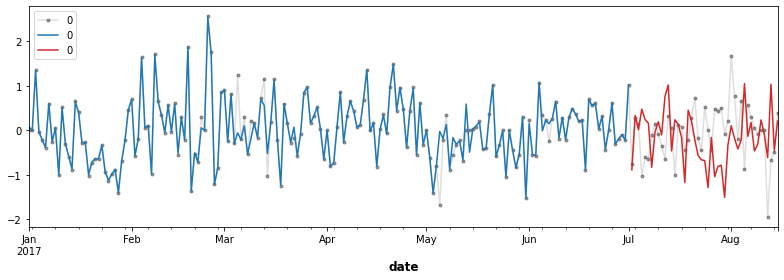

In [40]:
axs = y_deseason.plot(
    subplots=True, sharex=True, **plot_params, alpha=0.5,
)
_ = y_fit.plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.plot(subplots=True, sharex=True, color='C3', ax=axs)

ax.legend([])
ax.set_ylabel(sales_name);

### Forecasting With Machine Learning

Verileri hazırladık

onpromation bilgisi eklenmeli mi bak

In [41]:
y = y_deseason.copy()

X = make_lags(y, lags=4).fillna(0.0)
y = make_multistep_target(y, steps=16).fillna(0.0)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [43]:
# Linear
dp = DeterministicProcess(index=y.loc['2017'].index, order=1)
X_1 = dp.in_sample()

X_1['NewYear'] = (X.index.dayofyear == 1)
X_1_train = X_1.loc[X_train.index]
X_1_test = X_1.loc[X_test.index]

Modeli eğittik

In [44]:
# Model 1
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=MultiOutputRegressor(RandomForestRegressor()),
)
model.fit(X_1_train, X_train, y_train);

In [45]:
y_fit = pd.DataFrame(
    model.predict(X_1_train, X_train),
    index=X_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_1_test, X_test),
    index=X_test.index,
    columns=y_test.columns,
)

In [46]:
# satırları toplayıp tek bir sütun yaptık onu toplama olarak kullanmaya çalıştık ama mantıksız geldiği için kullanmadım
# y_pred_example = pd.DataFrame(y_pred.mean(axis=1).values)
# y_pred_example.columns = ['sales']
# y_pred_example.index = y_pred.index
#
# y_pred_example

Modeli, verileri test ediyoruz

In [47]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}\n"
      f"Test RMSE: {test_rmse:.2f}"
      )

Train RMSE: 0.30
Test RMSE: 0.60


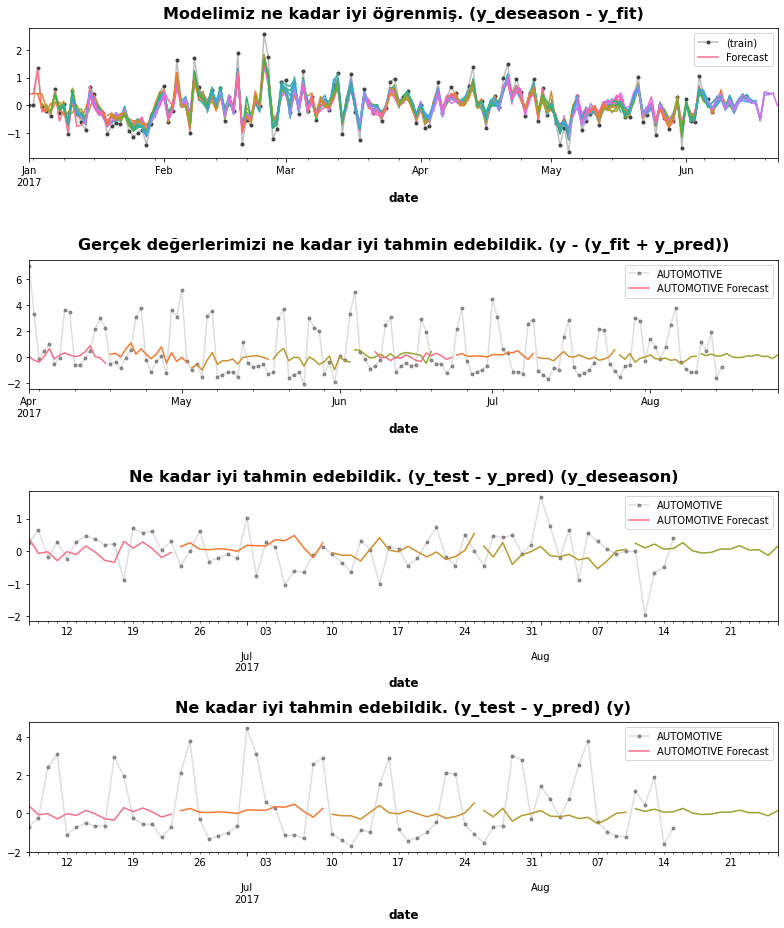

In [48]:
FAMILY = 'AUTOMOTIVE'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.loc[START:]
y_fit_ = y_fit.loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY] - 7
y_deseason_ = y_deseason.loc[START:, :]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 13))

ax1 = y_deseason.loc[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1)
ax1.legend(['(train)', 'Forecast'])
ax1.set_title('Modelimiz ne kadar iyi öğrenmiş. (y_deseason - y_fit)')

ax2 = y_.plot(**plot_params, ax=ax2, alpha=0.5)
ax2 = plot_multistep(y_fit_, ax=ax2, every=EVERY)
ax2 = plot_multistep(y_pred_, ax=ax2, every=EVERY)
ax2.legend([FAMILY, FAMILY + ' Forecast'])
ax2.set_title('Gerçek değerlerimizi ne kadar iyi tahmin edebildik. (y - (y_fit + y_pred))')

ax3 = y_deseason_.loc[y_pred.index].plot(**plot_params, ax=ax3, alpha=0.5)
# ax3 = plot_multistep(y_fit_, ax=ax3, every=EVERY)
ax3 = plot_multistep(y_pred_, ax=ax3, every=EVERY)
ax3.legend([FAMILY, FAMILY + ' Forecast'])
ax3.set_title('Ne kadar iyi tahmin edebildik. (y_test - y_pred) (y_deseason)')

ax4 = y_.loc[y_pred.index].plot(**plot_params, ax=ax4, alpha=0.5)
ax4 = plot_multistep(y_pred_, ax=ax4, every=EVERY)
ax4.legend([FAMILY, FAMILY + ' Forecast'])
ax4.set_title('Ne kadar iyi tahmin edebildik. (y_test - y_pred) (y)');

In [49]:
y = y_deseason.copy()

X = make_lags(y, lags=4).fillna(0.0)
# y = make_multistep_target(y, steps=16).fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Linear
dp = DeterministicProcess(index=y.loc['2017'].index, order=1)
X_1 = dp.in_sample()

X_1['NewYear'] = (X.index.dayofyear == 1)
X_1_train = X_1.loc[X_train.index]
X_1_test = X_1.loc[X_test.index]

model = BoostedHybrid(
    model_1=LinearRegression(fit_intercept=True),
    model_2=RandomForestRegressor(),
)
model.fit(X_1_train, X_train, y_train)

y_fit = pd.DataFrame(
    model.predict(X_1_train, X_train),
    index=X_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_1_test, X_test),
    index=X_test.index,
    columns=y_test.columns,
)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}\n"
      f"Test RMSE: {test_rmse:.2f}"
      )  # 0.29 0.62

Train RMSE: 0.29
Test RMSE: 0.60


In [50]:
X_1

,trend,NewYear
date,,
2017-01-01,1.0,True
2017-01-02,2.0,False
2017-01-03,3.0,False
2017-01-04,4.0,False
2017-01-05,5.0,False
...,...,...
2017-08-11,223.0,False
2017-08-12,224.0,False
2017-08-13,225.0,False


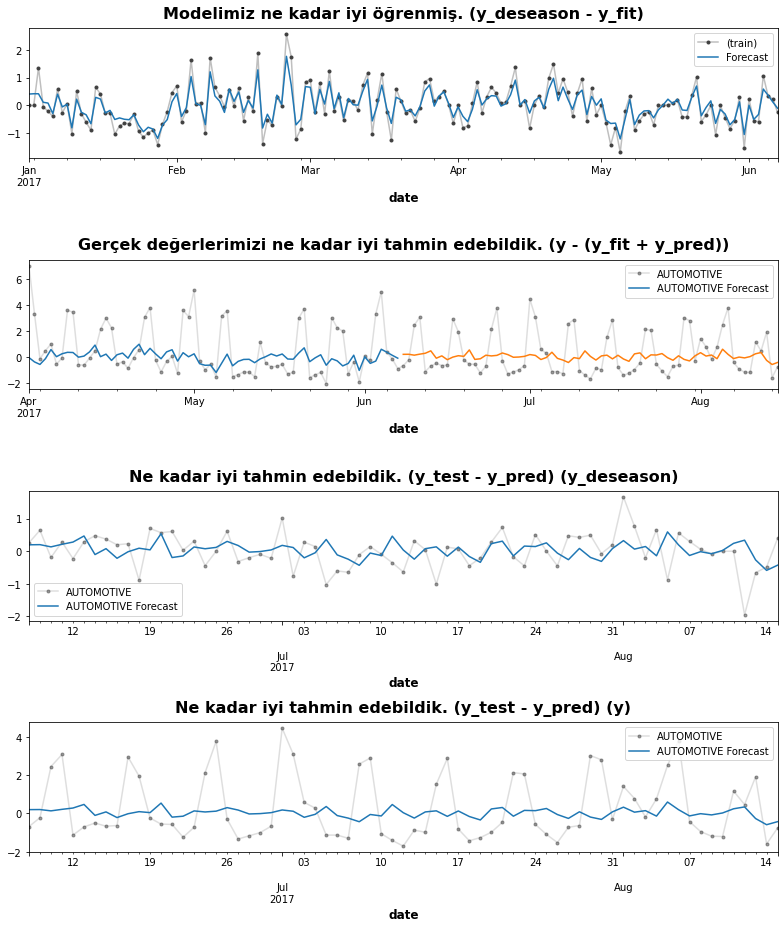

In [51]:
FAMILY = 'AUTOMOTIVE'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.loc[START:]
y_fit_ = y_fit.loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY] - 7
y_deseason_ = y_deseason.loc[START:, :]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 13))

ax1 = y_deseason.loc[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = y_fit.plot(ax=ax1)
ax1.legend(['(train)', 'Forecast'])
ax1.set_title('Modelimiz ne kadar iyi öğrenmiş. (y_deseason - y_fit)')

ax2 = y_.plot(**plot_params, ax=ax2, alpha=0.5)
ax2 = y_fit_.plot(ax=ax2)
ax2 = y_pred_.plot(ax=ax2)
ax2.legend([FAMILY, FAMILY + ' Forecast'])
ax2.set_title('Gerçek değerlerimizi ne kadar iyi tahmin edebildik. (y - (y_fit + y_pred))')

ax3 = y_deseason_.loc[y_pred.index].plot(**plot_params, ax=ax3, alpha=0.5)
ax3 = y_pred_.plot(ax=ax3)
ax3.legend([FAMILY, FAMILY + ' Forecast'])
ax3.set_title('Ne kadar iyi tahmin edebildik. (y_test - y_pred) (y_deseason)')

ax4 = y_.loc[y_pred.index].plot(**plot_params, ax=ax4, alpha=0.5)
ax4 = y_pred_.plot(ax=ax4)
ax4.legend([FAMILY, FAMILY + ' Forecast'])
ax4.set_title('Ne kadar iyi tahmin edebildik. (y_test - y_pred) (y)');

### Burada submission.csv'yi oluşturacağız

In [52]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

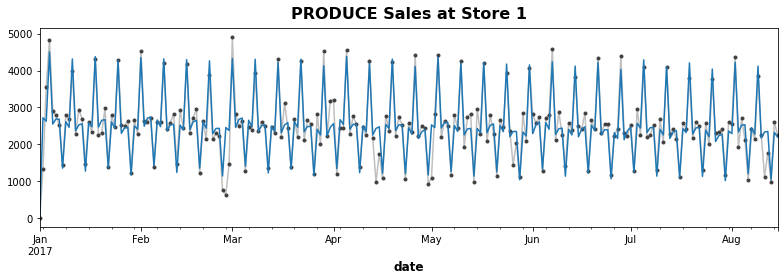

In [53]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [56]:
df_test = pd.read_csv(
    'C:\\Users\\Genos\\Projeler\\Python İle Makine Öğrenmesi\\Projeler\\Store Sales\\datasets\\test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

ValueError: columns overlap but no suffix specified: Index(['id'], dtype='object')

In [57]:
df_test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [1]:
import numpy as np
import cv2

pic_array = np.random.randint(255, size=(900, 800))
pic_array_8bit = slika_array.astype(np.uint8)
pic_g = cv2.imwrite("pic-from-random-array.png", pic_array_8bit)

ModuleNotFoundError: No module named 'cv2'